In [2]:
# necessary imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import re
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import tqdm

# Initial Dataset Creation #

In [3]:
df = pd.read_csv("Encoded_movie_data_with_budget_new 1.csv")

In [4]:
# need to rename columns for XGboost to work
df = df.rename(columns={'runtime_category_<100': 'runtime_category_less_than_100'})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   movie_searched                    1359 non-null   object 
 1   domestic_opening                  1359 non-null   int64  
 2   post_score                        1359 non-null   int64  
 3   budget_x                          1359 non-null   int64  
 4   Budget_new                        1359 non-null   int64  
 5   Missing Budget                    1359 non-null   int64  
 6   num_comments                      1359 non-null   int64  
 7   Comment_volume                    1359 non-null   int64  
 8   year                              1359 non-null   int64  
 9   WeightedAvg_Pos_Sentiment         1359 non-null   float64
 10  WeightedAvg_Neg_Sentiment         1359 non-null   float64
 11  WeightedAvg_Neut_Sentiment        1359 non-null   float64
 12  postiv

In [6]:
# drop Missing Budget flag
df = df.drop(columns=['Missing Budget', "Budget_new"])

In [7]:
# initiating dictionary of datasets
datasets = {}

# creating different datasets

# all rows
X_full = df.drop(columns=['domestic_opening', 'movie_searched'])

# all response rows
y_full= df['domestic_opening']

# dropping rows where budget_x != 0
X_budget_x_not_0 = df[df['budget_x'] != 0]

# create a corresponding y
y_budget_x_not_0 = X_budget_x_not_0['domestic_opening']

# drop columns that are not needed
X_budget_x_not_0 = X_budget_x_not_0.drop(columns=['domestic_opening', 'movie_searched'])

# dropping both budget columns
X_no_budget = df.drop(columns=['domestic_opening', 'movie_searched', 'budget_x'])


In [8]:
# add datasets to dictionary
datasets['X_full'] = (X_full, y_full)
datasets['X_budget_x_not_0'] = (X_budget_x_not_0, y_budget_x_not_0)
datasets['X_no_budget'] = (X_no_budget, y_full)

# Default Model Parameters on Full Dataset #

In [9]:
# split into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_full, y_full, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
rmse_train = np.sqrt(mean_squared_error(y_train, rf.predict(X_train)))
print("Train RMSE for Random Forest: ", rmse_train)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("Val RMSE for Random Forest: ", rmse)
train_r_squared = rf.score(X_train, y_train)
print("Train R^2 for Random Forest: ", train_r_squared)
r_squared = rf.score(X_val, y_val)
print("R^2 for Random Forest: ", r_squared)

print("\n")

# XGBoost
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)
rmse_train = np.sqrt(mean_squared_error(y_train, xgb.predict(X_train)))
print("Train RMSE for XGBoost: ", rmse_train)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("Val RMSE for XGBoost: ", rmse)
train_r_squared = xgb.score(X_train, y_train)
print("Train R^2 for XGBoost: ", train_r_squared)
r_squared = xgb.score(X_val, y_val)
print("R^2 for XGBoost: ", r_squared)


Train RMSE for Random Forest:  8201909.485729858
Val RMSE for Random Forest:  17592761.218741458
Train R^2 for Random Forest:  0.9343763195245159
R^2 for Random Forest:  0.6012344213939975


Train RMSE for XGBoost:  203359.58437442538
Val RMSE for XGBoost:  18193056.03167834
Train R^2 for XGBoost:  0.999959657767244
R^2 for XGBoost:  0.5735570286090715


# Examining Results for Feature Selection #

Holy cow those models look overfit. That gives is some clues as to other variations of the data we can run our cross-validation on. We can try investigating feature importances for each model and then make a dataset with only the more important features. We can also examine some outlier values for some of the features and remove those rows as well.

In [10]:
# create dataframe for permutation importance for Random Forest
perm_importance_rf = permutation_importance(rf, X_val, y_val, n_repeats=30, random_state=42)
perm_importance_rf_df = pd.DataFrame(data=perm_importance_rf.importances_mean, index=X_val.columns, columns=['importance'])
perm_importance_rf_df = perm_importance_rf_df.sort_values(by='importance', ascending=False)
print(perm_importance_rf_df)

                                    importance
budget_x                          1.025082e+00
Positive_Comments                 2.331323e-02
Genre_MCA_4                       1.841965e-02
negative_Neut_ratio               1.764229e-02
WeightedAvg_Pos_Sentiment         1.594375e-02
post_score                        1.142237e-02
postive_Neut_ratio                9.571777e-03
num_comments                      8.975416e-03
WeightedAvg_Neg_Sentiment         8.610251e-03
Negative_Comments                 8.268562e-03
Comment_volume                    8.236069e-03
WeightedAvg_Neut_Sentiment        7.097732e-03
runtime_category_121-150          5.250008e-03
Genre_MCA_6                       4.060149e-03
Genre_MCA_5                       4.055211e-03
year                              3.968237e-03
qtr_2                             2.086748e-03
runtime_category_less_than_100    1.266099e-03
runtime_category_150+             8.210077e-04
Rating Category_General Audience  2.958875e-04
qtr_1        

In [11]:
# list of features with importance scores > 0.005000
important_features_rf = perm_importance_rf_df[perm_importance_rf_df['importance'] > 0.005000].index.tolist()

# create new X containing only important features
X_important_rf_features = df[important_features_rf]

datasets['rf_important_features'] = (X_important_rf_features, y_full)

In [12]:
# create dataframe for permutation importance for XGBoost
perm_importance_xgb = permutation_importance(xgb, X_val, y_val, n_repeats=30, random_state=42)
perm_importance_xgb_df = pd.DataFrame(data=perm_importance_xgb.importances_mean, index=X_val.columns, columns=['importance'])
perm_importance_xgb_df = perm_importance_xgb_df.sort_values(by='importance', ascending=False)
print(perm_importance_xgb_df)

                                  importance
budget_x                            0.560370
Positive_Comments                   0.089511
WeightedAvg_Neut_Sentiment          0.050534
WeightedAvg_Neg_Sentiment           0.037293
num_comments                        0.028433
Negative_Comments                   0.015745
WeightedAvg_Pos_Sentiment           0.014985
Genre_MCA_5                         0.012373
Genre_MCA_1                         0.010336
negative_Neut_ratio                 0.008359
Genre_MCA_2                         0.008328
Genre_MCA_6                         0.006251
Genre_MCA_3                         0.004623
Rating Category_Adult               0.003951
big_production                      0.003142
runtime_category_less_than_100      0.001608
qtr_1                               0.000535
qtr_3                               0.000412
missing_sentiment                   0.000000
Documentary                         0.000000
Rating Category_Other              -0.000044
Rating Cat

In [13]:
# list of features with importance scores > 0.005000
important_features_xgb = perm_importance_xgb_df[perm_importance_xgb_df['importance'] > 0.005000].index.tolist()

# create new X containing only important features
X_important_xgb_features = df[important_features_xgb]

datasets['xgb_important_features'] = (X_important_xgb_features, y_full)

In [14]:
X_full.columns

Index(['post_score', 'budget_x', 'num_comments', 'Comment_volume', 'year',
       'WeightedAvg_Pos_Sentiment', 'WeightedAvg_Neg_Sentiment',
       'WeightedAvg_Neut_Sentiment', 'postive_Neut_ratio',
       'negative_Neut_ratio', 'big_production', 'Positive_Comments',
       'Negative_Comments', 'missing_sentiment', 'Genre_MCA_1', 'Genre_MCA_2',
       'Genre_MCA_3', 'Genre_MCA_4', 'Genre_MCA_5', 'Genre_MCA_6',
       'Rating Category_Adult', 'Rating Category_General Audience',
       'Rating Category_Not Rated', 'Rating Category_Other',
       'Rating Category_Teens+', 'runtime_category_less_than_100',
       'runtime_category_100-120', 'runtime_category_121-150',
       'runtime_category_150+', 'qtr_1', 'qtr_2', 'qtr_3', 'qtr_4',
       'Documentary'],
      dtype='object')

Now let's make some box plots to check outliers.

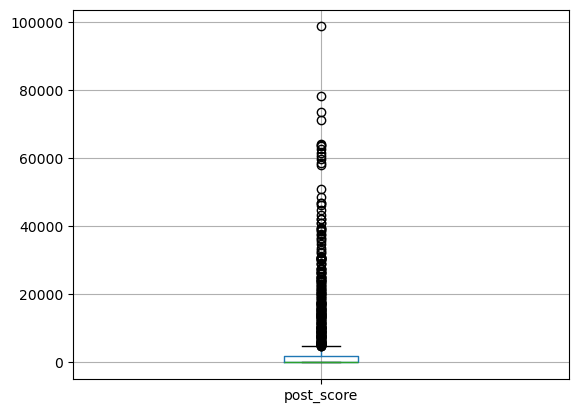

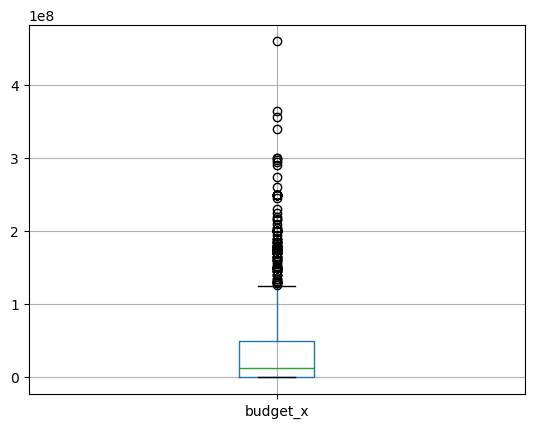

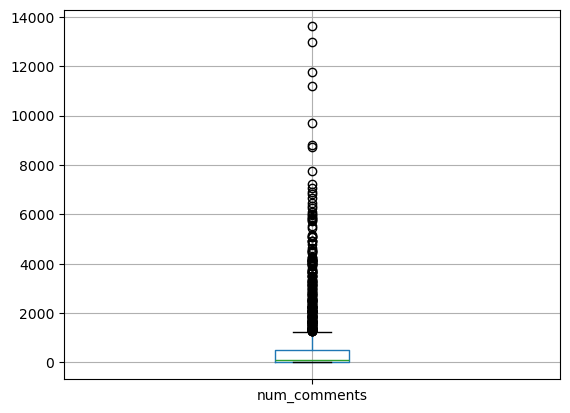

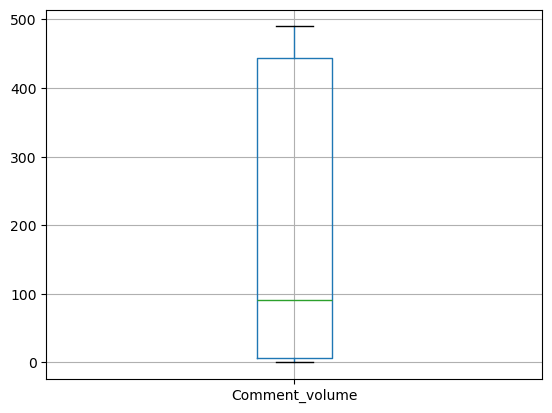

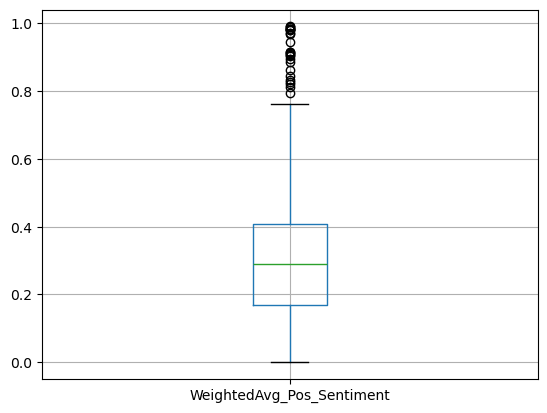

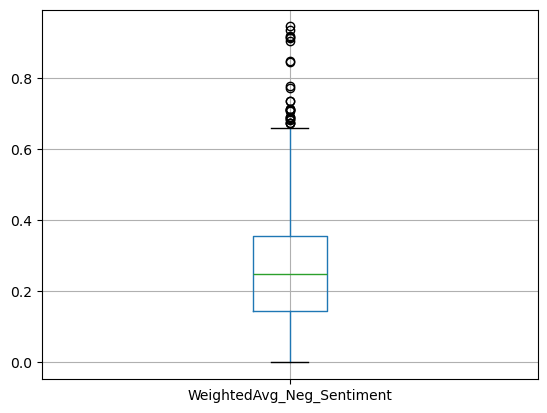

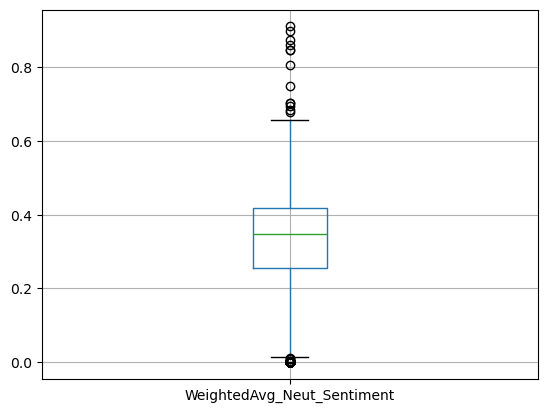

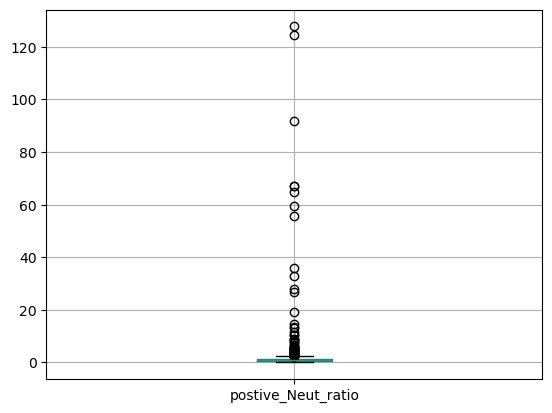

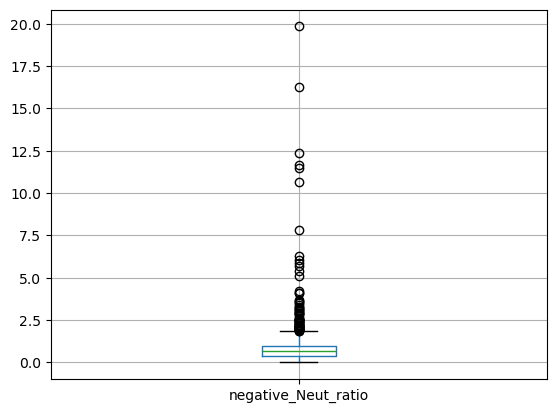

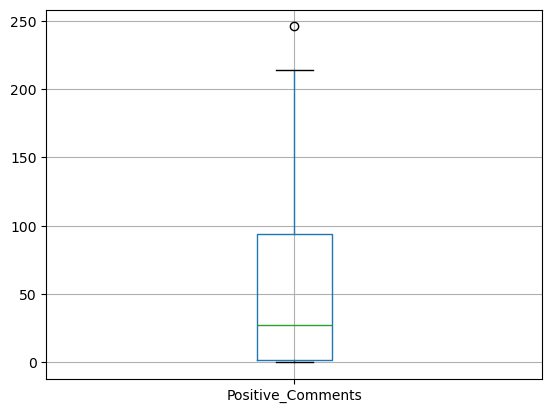

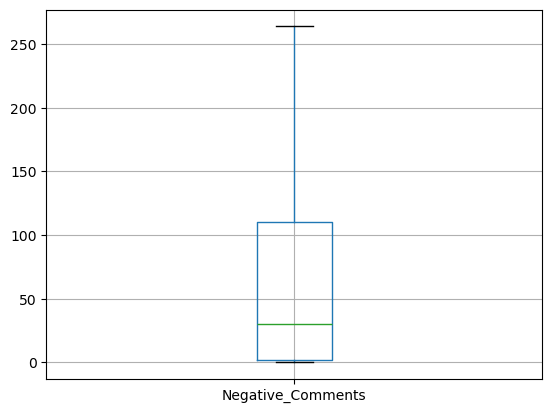

In [15]:
boxplot_cols = ['post_score', 'budget_x', 'num_comments', 'Comment_volume', 'WeightedAvg_Pos_Sentiment',
                'WeightedAvg_Neg_Sentiment', 'WeightedAvg_Neut_Sentiment', 'postive_Neut_ratio',
       'negative_Neut_ratio', 'Positive_Comments', 'Negative_Comments']

for i in boxplot_cols:
    df.boxplot(column = i)
    plt.show()

That's quite a few outliers to consider. Since our dataset is relatively small we want to minimize the number of data points we remove. However, we are setting all of this up to run a loop and find the best model, so we can afford to create a few datasets based on all of the above information.

We'll start by considering budget, since it is by far the most important feature for both RF and XGB.

In [16]:
# print index and movie_searched for 4 highest budget_x values
print(df.nlargest(4, 'budget_x')[['movie_searched', 'budget_x']])

               movie_searched   budget_x
115  Avatar: The Way of Water  460000000
116   Avengers: Age of Ultron  365000000
117         Avengers: Endgame  356000000
352                    Fast X  340000000


We'll try one run through only removing Avatar: The Way of Water since it's the largest budget outlier. We'll also try removing the top 4 based on the box plot.

In [17]:
biggest_budget_outlier_ind = 115
budget_outliers_inds = [115, 116, 117, 352]

In [18]:
# create new X's and y's
X_dropped_largest_budget_outlier = df.drop(index=biggest_budget_outlier_ind)
y_dropped_largest_budget_outlier = X_dropped_largest_budget_outlier['domestic_opening']
X_dropped_largest_budget_outlier = X_dropped_largest_budget_outlier.drop(columns=['domestic_opening', 'movie_searched'])
datasets['X_dropped_largest_budget_outlier'] = (X_dropped_largest_budget_outlier, y_dropped_largest_budget_outlier)

Since positive comments was the 2nd most important feature in both RF and XGB, we'll remove the one outlier from it as well.

In [19]:
# print index and movie_searched for highest positive_comments value
print(df[df['Positive_Comments'] == df['Positive_Comments'].max()][['movie_searched', 'Positive_Comments']])

              movie_searched  Positive_Comments
501  Insidious: The Red Door                246


In [20]:
X_dropped_pos_comments_outlier = df.drop(index=501)
y_dropped_pos_comments_outlier = X_dropped_pos_comments_outlier['domestic_opening']
X_dropped_pos_comments_outlier = X_dropped_pos_comments_outlier.drop(columns=['domestic_opening', 'movie_searched'])
datasets['X_dropped_pos_comments_outlier'] = (X_dropped_pos_comments_outlier, y_dropped_pos_comments_outlier)

We'll also create 2 additional sets - one that removes the comment outlier and the biggest budget outlier, and one that removes the comments outlier AND the 4 biggest budget outliers.

In [21]:
X_dropped_comment_and_budget_biggest_outlier = df.drop(index = [115, 501])
y_dropped_comment_and_budget_biggest_outlier = X_dropped_comment_and_budget_biggest_outlier['domestic_opening']
X_dropped_comment_and_budget_biggest_outlier = X_dropped_comment_and_budget_biggest_outlier.drop(columns=['domestic_opening', 'movie_searched'])
datasets['X_dropped_comment_and_budget_biggest_outlier'] = (X_dropped_comment_and_budget_biggest_outlier, y_dropped_comment_and_budget_biggest_outlier)

In [22]:
X_dropped_comment_and_4_budget_outliers = df.drop(index = [115, 116, 117, 352, 501])
y_dropped_comment_and_4_budget_outliers = X_dropped_comment_and_4_budget_outliers['domestic_opening']
X_dropped_comment_and_4_budget_outliers = X_dropped_comment_and_4_budget_outliers.drop(columns=['domestic_opening', 'movie_searched'])
datasets['X_dropped_comment_and_4_budget_outliers'] = (X_dropped_comment_and_4_budget_outliers, y_dropped_comment_and_4_budget_outliers)

I've honestly forgotten how many datasets we have so let's check that.

In [23]:
# length of datasets
print(len(datasets))

9


In [24]:
datasets.keys()

dict_keys(['X_full', 'X_budget_x_not_0', 'X_no_budget', 'rf_important_features', 'xgb_important_features', 'X_dropped_largest_budget_outlier', 'X_dropped_pos_comments_outlier', 'X_dropped_comment_and_budget_biggest_outlier', 'X_dropped_comment_and_4_budget_outliers'])

Ok, 9 datasets each run on 2 different models seems like a reasonable amount. Also, none of the other outliers were particularly high in the importance scores of either baseline model.

# GridSearchCV for RF and XGB On 9 Datasets #

First we need a test set for each dataset.

In [25]:
# train test split for each dataset in datasets
for key in datasets.keys():
    X_train, X_test, y_train, y_test = train_test_split(datasets[key][0], datasets[key][1], test_size=0.2, random_state=42)
    datasets[key] = (X_train, X_test, y_train, y_test)
    for i in datasets[key]:
        print(i.shape) # printing shape to make sure this is working correctly

(1087, 34)
(272, 34)
(1087,)
(272,)
(751, 34)
(188, 34)
(751,)
(188,)
(1087, 33)
(272, 33)
(1087,)
(272,)
(1087, 13)
(272, 13)
(1087,)
(272,)
(1087, 12)
(272, 12)
(1087,)
(272,)
(1086, 34)
(272, 34)
(1086,)
(272,)
(1086, 34)
(272, 34)
(1086,)
(272,)
(1085, 34)
(272, 34)
(1085,)
(272,)
(1083, 34)
(271, 34)
(1083,)
(271,)


In [ ]:
'''
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20, 40],
    'min_samples_leaf': [1, 2, 4, 8, 16]
}

xgb_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5]
}

# Initialize dictionary to store results
results = {}

    #initialize models
rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
grid_search_rf = GridSearchCV(rf, rf_param_grid, cv=5, n_jobs=-1, verbose = 2)
grid_search_xgb = GridSearchCV(xgb, xgb_param_grid, cv=5, n_jobs=-1, verbose = 2)

# loop to run randomforest and xgb with gridsearch cv on each dataset and store results in results
for name, (X_variant_train, X_variant_test, y_variant_train, y_variant_test) in tqdm.tqdm(datasets.items(), desc="Processing datasets"):

    # fit models on training data
    grid_search_rf.fit(X_variant_train, y_variant_train)
    grid_search_xgb.fit(X_variant_train, y_variant_train)

    # retrain models on best parameters

    rf_best = RandomForestRegressor(random_state=42, **grid_search_rf.best_params_)
    xgb_best = XGBRegressor(random_state=42, **grid_search_xgb.best_params_)
    rf_best.fit(X_variant_train, y_variant_train)
    xgb_best.fit(X_variant_train, y_variant_train)

    # get R^2, Adjusted R^2, MSE, RMSE, and AME for each model on training set
    rf_train_r_squared = rf_best.score(X_variant_train, y_variant_train)
    xgb_train_r_squared = xgb_best.score(X_variant_train, y_variant_train)
    rf_train_adjusted_r_squared = 1 - (1-rf_train_r_squared)*(len(y_variant_train)-1)/(len(y_variant_train)-X_variant_train.shape[1]-1)
    xgb_train_adjusted_r_squared = 1 - (1-xgb_train_r_squared)*(len(y_variant_train)-1)/(len(y_variant_train)-X_variant_train.shape[1]-1)
    rf_train_mse = mean_squared_error(y_variant_train, rf_best.predict(X_variant_train))
    xgb_train_mse = mean_squared_error(y_variant_train, xgb_best.predict(X_variant_train))
    rf_train_rmse = np.sqrt(rf_train_mse)
    xgb_train_rmse = np.sqrt(xgb_train_mse)
    rf_train_ame = np.mean(np.abs(y_variant_train - rf_best.predict(X_variant_train)))
    xgb_train_ame = np.mean(np.abs(y_variant_train - xgb_best.predict(X_variant_train)))

    # print training set values
    print(name)
    print("Random Forest")
    print("R^2: ", rf_train_r_squared)
    print("Adjusted R^2: ", rf_train_adjusted_r_squared)
    print("MSE: ", rf_train_mse)
    print("RMSE: ", rf_train_rmse)
    print("AME: ", rf_train_ame)
    print("\n")
    print("XGBoost")
    print("R^2: ", xgb_train_r_squared)
    print("Adjusted R^2: ", xgb_train_adjusted_r_squared)
    print("MSE: ", xgb_train_mse)
    print("RMSE: ", xgb_train_rmse)
    print("AME: ", xgb_train_ame)
    print("\n")

    # get same values on test set
    rf_test_r_squared = rf_best.score(X_variant_test, y_variant_test)
    xgb_test_r_squared = xgb_best.score(X_variant_test, y_variant_test)
    rf_test_adjusted_r_squared = 1 - (1-rf_test_r_squared)*(len(y_variant_test)-1)/(len(y_variant_test)-X_variant_test.shape[1]-1)
    xgb_test_adjusted_r_squared = 1 - (1-xgb_test_r_squared)*(len(y_variant_test)-1)/(len(y_variant_test)-X_variant_test.shape[1]-1)
    rf_test_mse = mean_squared_error(y_variant_test, rf_best.predict(X_variant_test))
    xgb_test_mse = mean_squared_error(y_variant_test, xgb_best.predict(X_variant_test))
    rf_test_rmse = np.sqrt(rf_test_mse)
    xgb_test_rmse = np.sqrt(xgb_test_mse)
    rf_test_ame = np.mean(np.abs(y_variant_test - rf_best.predict(X_variant_test)))
    xgb_test_ame = np.mean(np.abs(y_variant_test - xgb_best.predict(X_variant_test)))

    # store results in dictionary
    results[name] = {
        'rf_train_r_squared': rf_train_r_squared,
        'xgb_train_r_squared': xgb_train_r_squared,
        'rf_train_adjusted_r_squared': rf_train_adjusted_r_squared,
        'xgb_train_adjusted_r_squared': xgb_train_adjusted_r_squared,
        'rf_train_mse': rf_train_mse,
        'xgb_train_mse': xgb_train_mse,
        'rf_train_rmse': rf_train_rmse,
        'xgb_train_rmse': xgb_train_rmse,
        'rf_train_ame': rf_train_ame,
        'xgb_train_ame': xgb_train_ame,
        'rf_test_r_squared': rf_test_r_squared,
        'xgb_test_r_squared': xgb_test_r_squared,
        'rf_test_adjusted_r_squared': rf_test_adjusted_r_squared,
        'xgb_test_adjusted_r_squared': xgb_test_adjusted_r_squared,
        'rf_test_mse': rf_test_mse,
        'xgb_test_mse': xgb_test_mse,
        'rf_test_rmse': rf_test_rmse,
        'xgb_test_rmse': xgb_test_rmse,
        'rf_test_ame': rf_test_ame,
        'xgb_test_ame': xgb_test_ame
    }

'''

In [29]:
def evaluate_models_on_dataset(X_train, X_test, y_train, y_test, rf_param_grid, xgb_param_grid, results, dataset_name):
    # Initialize models
    print("Initializing RF")
    rf = RandomForestRegressor(random_state=42)
    print("Initializing XGB")
    xgb = XGBRegressor(random_state=42)


    # Set up grid search objects
    print("Setting up RF Grid Search")
    grid_search_rf = GridSearchCV(rf, rf_param_grid, cv=5, n_jobs=-1, verbose=2)
    print("Setting up XGB Grid Search")
    grid_search_xgb = GridSearchCV(xgb, xgb_param_grid, cv=5, n_jobs=-1, verbose=2)


    # Fit grid search on training data
    print("Fitting RF")
    grid_search_rf.fit(X_train, y_train)
    print("Fitting XGB")
    grid_search_xgb.fit(X_train, y_train)


    # Get best parameters
    rf_best_params = grid_search_rf.best_params_
    xgb_best_params = grid_search_xgb.best_params_


    # Retrain models on best parameters
    print("Retraining RF with best params")
    rf_best = RandomForestRegressor(random_state=42, **rf_best_params)
    print("Retraining XGB with best params")
    xgb_best = XGBRegressor(random_state=42, **xgb_best_params)
    print("Fitting RF with best params")
    rf_best.fit(X_train, y_train)
    print("Fitting XGB with best params")
    xgb_best.fit(X_train, y_train)


    # Calculate evaluation metrics
    rf_train_mse = mean_squared_error(y_train, rf_best.predict(X_train))
    xgb_train_mse = mean_squared_error(y_train, xgb_best.predict(X_train))
    rf_test_mse = mean_squared_error(y_test, rf_best.predict(X_test))
    xgb_test_mse = mean_squared_error(y_test, xgb_best.predict(X_test))
    rf_train_rmse = np.sqrt(rf_train_mse)
    xgb_train_rmse = np.sqrt(xgb_train_mse)
    rf_test_rmse = np.sqrt(rf_test_mse)
    xgb_test_rmse = np.sqrt(xgb_test_mse)
    rf_train_r_squared = rf_best.score(X_train, y_train)
    xgb_train_r_squared = xgb_best.score(X_train, y_train)
    rf_test_r_squared = rf_best.score(X_test, y_test)
    xgb_test_r_squared = xgb_best.score(X_test, y_test)
    rf__train_adjusted_r_squared = 1 - (1-rf_train_r_squared)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
    xgb__train_adjusted_r_squared = 1 - (1-xgb_train_r_squared)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
    rf_test_adjusted_r_squared = 1 - (1-rf_test_r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    xgb_test_adjusted_r_squared = 1 - (1-xgb_test_r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    rf_train_median_absolute_error = np.median(np.abs(y_train - rf_best.predict(X_train)))
    xgb_train_median_absolute_error = np.median(np.abs(y_train - xgb_best.predict(X_train)))
    rf_test_median_absolute_error = np.median(np.abs(y_test - rf_best.predict(X_test)))
    xgb_test_median_absolute_error = np.median(np.abs(y_test - xgb_best.predict(X_test)))
   
    # save metrics to results dictionary
    results[dataset_name] = {
        'rf_train_mse': rf_train_mse,
        'xgb_train_mse': xgb_train_mse,
        'rf_test_mse': rf_test_mse,
        'xgb_test_mse': xgb_test_mse,
        'rf_train_rmse': rf_train_rmse,
        'xgb_train_rmse': xgb_train_rmse,
        'rf_test_rmse': rf_test_rmse,
        'xgb_test_rmse': xgb_test_rmse,
        'rf_train_r_squared': rf_train_r_squared,
        'xgb_train_r_squared': xgb_train_r_squared,
        'rf_test_r_squared': rf_test_r_squared,
        'xgb_test_r_squared': xgb_test_r_squared,
        'rf_train_adjusted_r_squared': rf__train_adjusted_r_squared,
        'xgb_train_adjusted_r_squared': xgb__train_adjusted_r_squared,
        'rf_test_adjusted_r_squared': rf_test_adjusted_r_squared,
        'xgb_test_adjusted_r_squared': xgb_test_adjusted_r_squared,
        'rf_train_median_absolute_error': rf_train_median_absolute_error,
        'xgb_train_median_absolute_error': xgb_train_median_absolute_error,
        'rf_test_median_absolute_error': rf_test_median_absolute_error,
        'xgb_test_median_absolute_error': xgb_test_median_absolute_error
    }


    print(results[dataset_name])


In [30]:
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20, 40],
    'min_samples_leaf': [1, 2, 4, 8, 16]
}

xgb_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5]
}

# Initialize dictionary to store results
results = {}

In [ ]:
# run evalute_models_on_dataset on X_full
evaluate_models_on_dataset(datasets['X_full'][0], datasets['X_full'][1], datasets['X_full'][2], datasets['X_full'][3], rf_param_grid, xgb_param_grid, results, 'X_full')

In [34]:
# run evalute_models_on_dataset on X_budget_x_not_0
evaluate_models_on_dataset(datasets['X_budget_x_not_0'][0], datasets['X_budget_x_not_0'][1], datasets['X_budget_x_not_0'][2], datasets['X_budget_x_not_0'][3], rf_param_grid, xgb_param_grid, results, 'X_budget_x_not_0')

Initializing RF
Initializing XGB
Setting up RF Grid Search
Setting up XGB Grid Search
Fitting RF
Fitting 5 folds for each of 625 candidates, totalling 3125 fits
Fitting XGB
Fitting 5 folds for each of 125 candidates, totalling 625 fits


c:\Users\schcb\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Retraining RF with best params
Retraining XGB with best params
Fitting RF with best params
Fitting XGB with best params
{'rf_train_mse': 265906261915030.78, 'xgb_train_mse': 74488844498115.98, 'rf_test_mse': 446165308581369.0, 'xgb_test_mse': 856156921305185.4, 'rf_train_rmse': 16306632.451705987, 'xgb_train_rmse': 8630692.005749943, 'rf_test_rmse': 21122625.513448108, 'xgb_test_rmse': 29260159.283660527, 'rf_train_r_squared': 0.7743377408535521, 'xgb_train_r_squared': 0.9367847872043545, 'rf_test_r_squared': 0.6947419318395142, 'xgb_test_r_squared': 0.4142332386378563, 'rf_train_adjusted_r_squared': 0.7636219352516258, 'xgb_train_adjusted_r_squared': 0.9337829474905949, 'rf_test_adjusted_r_squared': 0.6269068055816284, 'xgb_test_adjusted_r_squared': 0.2840628472240466, 'rf_train_median_absolute_error': 3352794.546010198, 'xgb_train_median_absolute_error': 2800286.0, 'rf_test_median_absolute_error': 6310023.183926245, 'xgb_test_median_absolute_error': 8040419.75}


In [ ]:
# run evalute_models_on_dataset on X_no_budget
evaluate_models_on_dataset(datasets['X_no_budget'][0], datasets['X_no_budget'][1], datasets['X_no_budget'][2], datasets['X_no_budget'][3], rf_param_grid, xgb_param_grid, results, 'X_no_budget')

In [ ]:
# run evalute_models_on_dataset on rf_important_features
evaluate_models_on_dataset(datasets['rf_important_features'][0], datasets['rf_important_features'][1], datasets['rf_important_features'][2], datasets['rf_important_features'][3], rf_param_grid, xgb_param_grid, results, 'rf_important_features')

In [31]:
# run evaluate_models_on_dataset on xgb_important_features
evaluate_models_on_dataset(datasets['xgb_important_features'][0], datasets['xgb_important_features'][1], datasets['xgb_important_features'][2], datasets['xgb_important_features'][3], rf_param_grid, xgb_param_grid, results, 'xgb_important_features')

Initializing RF
Initializing XGB
Setting up RF Grid Search
Setting up XGB Grid Search
Fitting RF
Fitting 5 folds for each of 625 candidates, totalling 3125 fits
Fitting XGB
Fitting 5 folds for each of 125 candidates, totalling 625 fits


c:\Users\schcb\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Retraining RF with best params
Retraining XGB with best params
Fitting RF with best params
Fitting XGB with best params
{'rf_train_mse': 174061836120495.03, 'xgb_train_mse': 394224115431.0415, 'rf_test_mse': 266568506089355.75, 'xgb_test_mse': 339359313170191.5, 'rf_train_rmse': 13193249.642165309, 'xgb_train_rmse': 627872.6904644297, 'rf_test_rmse': 16326925.800326152, 'xgb_test_rmse': 18421707.66162007, 'rf_train_r_squared': 0.8257915266208334, 'xgb_train_r_squared': 0.999605443773034, 'rf_test_r_squared': 0.6420464844205732, 'xgb_test_r_squared': 0.5443015344311888, 'rf_train_adjusted_r_squared': 0.823845063231122, 'xgb_train_adjusted_r_squared': 0.9996010353235707, 'rf_test_adjusted_r_squared': 0.6254617655520284, 'xgb_test_adjusted_r_squared': 0.5231880920110121, 'rf_train_median_absolute_error': 1728336.1963800646, 'xgb_train_median_absolute_error': 179009.10546875, 'rf_test_median_absolute_error': 1774942.2462032554, 'xgb_test_median_absolute_error': 1853757.0}


In [35]:
# run evalute_models_on_dataset on X_dropped_largest_budget_outlier
evaluate_models_on_dataset(datasets['X_dropped_largest_budget_outlier'][0], datasets['X_dropped_largest_budget_outlier'][1], datasets['X_dropped_largest_budget_outlier'][2], datasets['X_dropped_largest_budget_outlier'][3], rf_param_grid, xgb_param_grid, results, 'X_dropped_largest_budget_outlier')

Initializing RF
Initializing XGB
Setting up RF Grid Search
Setting up XGB Grid Search
Fitting RF
Fitting 5 folds for each of 625 candidates, totalling 3125 fits
Fitting XGB
Fitting 5 folds for each of 125 candidates, totalling 625 fits


c:\Users\schcb\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Retraining RF with best params
Retraining XGB with best params
Fitting RF with best params
Fitting XGB with best params
{'rf_train_mse': 251550530700536.7, 'xgb_train_mse': 185.05185361984996, 'rf_test_mse': 281965871727590.75, 'xgb_test_mse': 249580961491541.12, 'rf_train_rmse': 15860344.59589503, 'xgb_train_rmse': 13.60337655215976, 'rf_test_rmse': 16791839.438476976, 'xgb_test_rmse': 15798131.582296088, 'rf_train_r_squared': 0.7411609233881205, 'xgb_train_r_squared': 0.9999999999998096, 'rf_test_r_squared': 0.6514831679940588, 'xgb_test_r_squared': 0.6915117226950651, 'rf_train_adjusted_r_squared': 0.7327874423178979, 'xgb_train_adjusted_r_squared': 0.9999999999998035, 'rf_test_adjusted_r_squared': 0.6014849726851896, 'xgb_test_adjusted_r_squared': 0.6472560204656652, 'rf_train_median_absolute_error': 2111631.9271054454, 'xgb_train_median_absolute_error': 4.196258544921875, 'rf_test_median_absolute_error': 2236457.04201654, 'xgb_test_median_absolute_error': 2534241.359375}


In [36]:
# run evalute_models_on_dataset on X_dropped_comment_and_budget_biggest_outlier
evaluate_models_on_dataset(datasets['X_dropped_comment_and_budget_biggest_outlier'][0], datasets['X_dropped_comment_and_budget_biggest_outlier'][1], datasets['X_dropped_comment_and_budget_biggest_outlier'][2], datasets['X_dropped_comment_and_budget_biggest_outlier'][3], rf_param_grid, xgb_param_grid, results, 'X_dropped_comment_and_budget_biggest_outlier')

Initializing RF
Initializing XGB
Setting up RF Grid Search
Setting up XGB Grid Search
Fitting RF
Fitting 5 folds for each of 625 candidates, totalling 3125 fits
Fitting XGB
Fitting 5 folds for each of 125 candidates, totalling 625 fits


c:\Users\schcb\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Retraining RF with best params
Retraining XGB with best params
Fitting RF with best params
Fitting XGB with best params
{'rf_train_mse': 302666030382580.3, 'xgb_train_mse': 226780396730466.34, 'rf_test_mse': 232438900951600.9, 'xgb_test_mse': 315577735256614.56, 'rf_train_rmse': 17397299.5140792, 'xgb_train_rmse': 15059229.61942165, 'rf_test_rmse': 15245947.033608668, 'xgb_test_rmse': 17764507.740340415, 'rf_train_r_squared': 0.6926962722084378, 'xgb_train_r_squared': 0.7697446878421389, 'rf_test_r_squared': 0.6940771483187209, 'xgb_test_r_squared': 0.5846545466288984, 'rf_train_adjusted_r_squared': 0.68274548483233, 'xgb_train_adjusted_r_squared': 0.7622888015436938, 'rf_test_adjusted_r_squared': 0.650189481832799, 'xgb_test_adjusted_r_squared': 0.5250691229385294, 'rf_train_median_absolute_error': 2310243.501595143, 'xgb_train_median_absolute_error': 5667926.0, 'rf_test_median_absolute_error': 2706260.81978954, 'xgb_test_median_absolute_error': 5697944.0}


In [38]:
# run evalute_models_on_dataset on X_dropped_4_budget_outliers
evaluate_models_on_dataset(datasets['X_dropped_comment_and_4_budget_outliers'][0], datasets['X_dropped_comment_and_4_budget_outliers'][1], datasets['X_dropped_comment_and_4_budget_outliers'][2], datasets['X_dropped_comment_and_4_budget_outliers'][3], rf_param_grid, xgb_param_grid, results, 'X_dropped_comment_and_4_budget_outliers')


Initializing RF
Initializing XGB
Setting up RF Grid Search
Setting up XGB Grid Search
Fitting RF
Fitting 5 folds for each of 625 candidates, totalling 3125 fits
Fitting XGB
Fitting 5 folds for each of 125 candidates, totalling 625 fits
Retraining RF with best params
Retraining XGB with best params
Fitting RF with best params
Fitting XGB with best params
{'rf_train_mse': 189219206786431.66, 'xgb_train_mse': 45835527686392.79, 'rf_test_mse': 334229510471126.56, 'xgb_test_mse': 474306827298844.25, 'rf_train_rmse': 13755697.248283405, 'xgb_train_rmse': 6770194.065637468, 'rf_test_rmse': 18281944.931301117, 'xgb_test_rmse': 21778586.439409796, 'rf_train_r_squared': 0.761814187326649, 'xgb_train_r_squared': 0.9423030431386514, 'rf_test_r_squared': 0.6559765433355476, 'xgb_test_r_squared': 0.5117945329935369, 'rf_train_adjusted_r_squared': 0.7540867850070937, 'xgb_train_adjusted_r_squared': 0.9404311953015466, 'rf_test_adjusted_r_squared': 0.6064138419516858, 'xgb_test_adjusted_r_squared': 0.

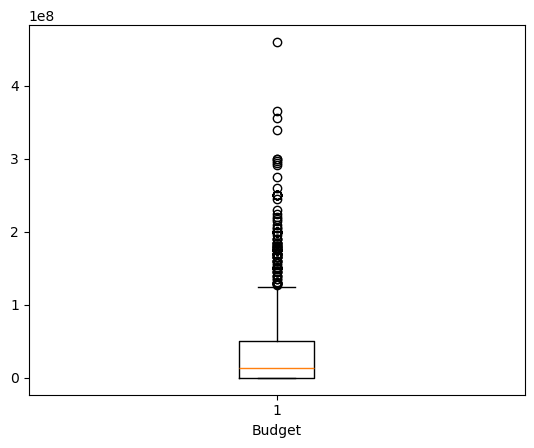

In [40]:
# boxplot for df['budget_x] with "Budget" as x label
plt.boxplot(df['budget_x'])
plt.xlabel("Budget")
plt.show()

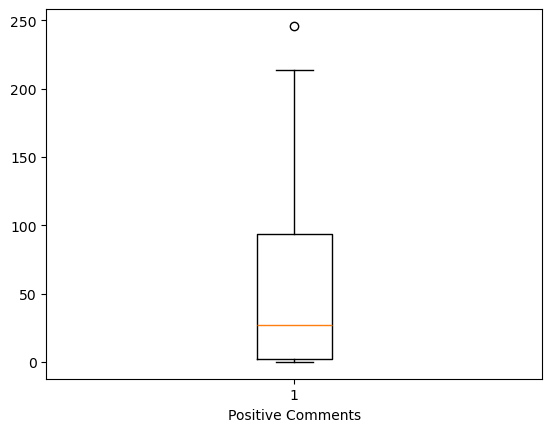

In [42]:
plt.boxplot(df['Positive_Comments'])
plt.xlabel("Positive Comments")
plt.show()

# Model Exploration of Best Model - X_full RF #

In [44]:
X_train = datasets['X_full'][0]
y_train = datasets['X_full'][2]
X_test = datasets['X_full'][1]
y_test = datasets['X_full'][3]

# hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20, 40],
    'min_samples_leaf': [1, 2, 4, 8, 16]
}

rf = RandomForestRegressor(random_state=42)

# Grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit grid search on X_full
grid_search.fit(X_train, y_train)


print(grid_search.best_params_)

Fitting 5 folds for each of 625 candidates, totalling 3125 fits
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}


In [45]:
# retrain model with best parameters
rf = RandomForestRegressor(n_estimators = grid_search.best_params_['n_estimators'], 
                           max_depth = grid_search.best_params_['max_depth'], 
                           min_samples_split = grid_search.best_params_['min_samples_split'], 
                           min_samples_leaf = grid_search.best_params_['min_samples_leaf'], 
                           random_state=42)
rf.fit(X_train, y_train)

# evaluate model on training set
y_pred_train = rf.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("Train RMSE: ", rmse_train)
train_r_squared = rf.score(X_train, y_train)
print("Train R^2: ", train_r_squared)
train_adj_r_squared = 1 - (1-train_r_squared)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print("Train Adj R^2", train_adj_r_squared)

# evaluate model on test set
y_pred_test = rf.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Test RMSE: ", rmse_test)
test_r_squared = rf.score(X_test, y_test)
print("Test R^2: ", test_r_squared)
test_adj_r_squared = 1 - (1-test_r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print("Test Adj R^2", test_adj_r_squared)


Train RMSE:  12406921.016590072
Train R^2:  0.8459386321404899
Train Adj R^2 0.8409594624568175
Test RMSE:  15048720.707630383
Test R^2:  0.6958996232194665
Test Adj R^2 0.6522734088290103


In [53]:
# Permutation importance
perm_importance_rf = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=42)
perm_importance_rf_df = pd.DataFrame(data=perm_importance_rf.importances_mean, index=X_test.columns, columns=['importance'])
perm_importance_rf_df = perm_importance_rf_df.sort_values(by='importance', ascending=False)

# Normalize importance scores to sum to 1
perm_importance_rf_df['importance'] = perm_importance_rf_df['importance'] / perm_importance_rf_df['importance'].sum()

# Set display format for floating points to avoid scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

# Print the DataFrame
print(perm_importance_rf_df)

                                  importance
budget_x                            0.945165
Negative_Comments                   0.016021
Genre_MCA_4                         0.015023
qtr_2                               0.007184
Genre_MCA_3                         0.005719
WeightedAvg_Neut_Sentiment          0.004982
year                                0.004589
Positive_Comments                   0.003790
post_score                          0.003367
Genre_MCA_2                         0.002256
qtr_4                               0.002169
num_comments                        0.001015
Genre_MCA_5                         0.000948
runtime_category_100-120            0.000611
runtime_category_less_than_100      0.000291
Rating Category_Adult               0.000093
qtr_1                               0.000052
Rating Category_General Audience    0.000035
Rating Category_Teens+              0.000005
Rating Category_Not Rated           0.000000
Documentary                         0.000000
Rating Cat

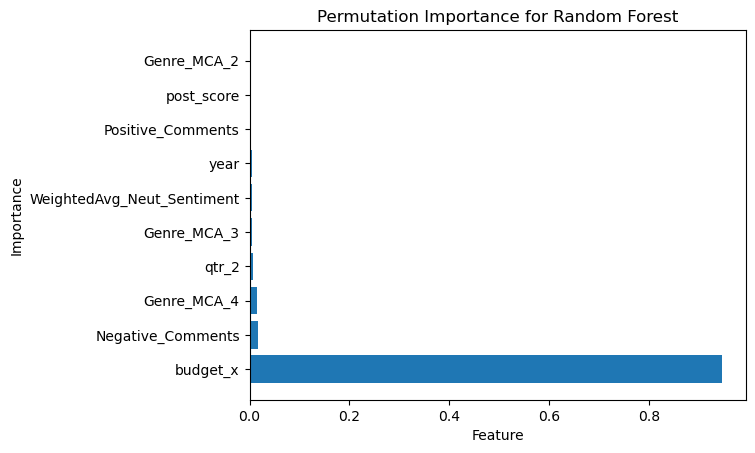

In [56]:
# plot 10 most important features
plt.barh(perm_importance_rf_df.index[:10], perm_importance_rf_df['importance'][:10])
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.title("Permutation Importance for Random Forest")
# change label Genre
plt.show()

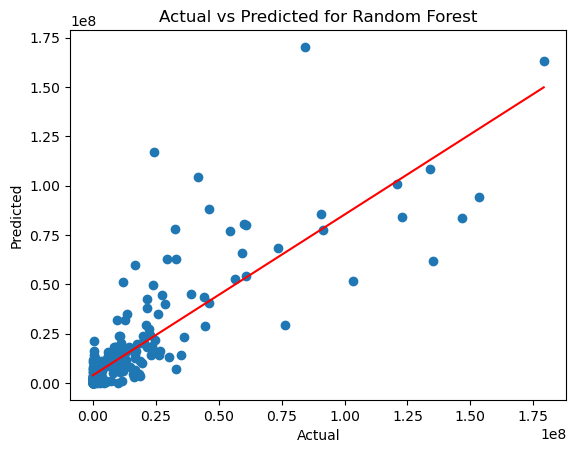

In [58]:
# plot actual vs predicted with line of best fit for Random Forest test set
plt.scatter(y_test, y_pred_test)
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred_test, 1))(np.unique(y_test)), color='red')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted for Random Forest")
plt.show()

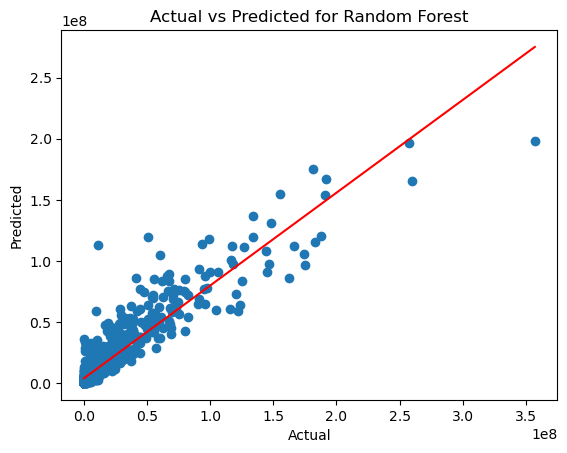

In [59]:
# plot actual vs predicted with line of best fit for Random Forest training set
plt.scatter(y_train, y_pred_train)
plt.plot(np.unique(y_train), np.poly1d(np.polyfit(y_train, y_pred_train, 1))(np.unique(y_train)), color='red')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted for Random Forest")
plt.show()

In [140]:
# create new dataframe containing X_full and y_full along with their predicted y values
df_with_preds = X_full.copy()
df_with_preds['domestic_opening'] = y_full
df_with_preds['predicted_domestic_opening'] = rf.predict(X_full)
# cast predicted_domestic_opening to integer value
df_with_preds['predicted_domestic_opening'] = df_with_preds['predicted_domestic_opening'].astype(int)
# add movie_searched column 
df_with_preds['movie_searched'] = df['movie_searched']
# add error term
df_with_preds['error'] = df_with_preds['domestic_opening'] - df_with_preds['predicted_domestic_opening']
# add absolute error term
df_with_preds['abs_error'] = np.abs(df_with_preds['error'])
# add pct err
df_with_preds['pct_err'] = df_with_preds['error'] / df_with_preds['domestic_opening']

c:\Users\schcb\anaconda3\Lib\site-packages\matplotlib\text.py:753: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
c:\Users\schcb\anaconda3\Lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
c:\Users\schcb\anaconda3\Lib\site-packages\matplotlib\text.py:894: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
c:\Users\schcb\anaconda3\Lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yun

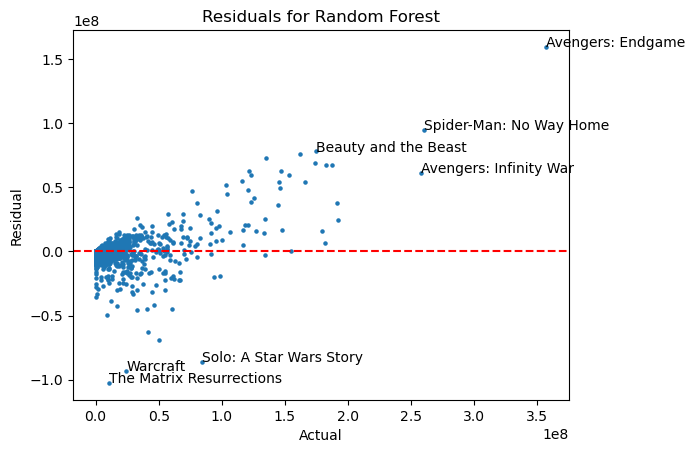

In [141]:
# plot residuals for df_with_preds
plt.scatter(df_with_preds['domestic_opening'], df_with_preds['domestic_opening'] - df_with_preds['predicted_domestic_opening'], s = 5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Actual")
plt.ylabel("Residual")
plt.title("Residuals for Random Forest")
# add movie title to 3 largest residuals
for i in df_with_preds.nlargest(3, 'error')['movie_searched']:
    plt.text(df_with_preds[df_with_preds['movie_searched'] == i]['domestic_opening'], df_with_preds[df_with_preds['movie_searched'] == i]['domestic_opening'] - df_with_preds[df_with_preds['movie_searched'] == i]['predicted_domestic_opening'], i)
# add movie title to 2 smallest residuals
for i in df_with_preds.nsmallest(3, 'error')['movie_searched']:
    plt.text(df_with_preds[df_with_preds['movie_searched'] == i]['domestic_opening'], df_with_preds[df_with_preds['movie_searched'] == i]['domestic_opening'] - df_with_preds[df_with_preds['movie_searched'] == i]['predicted_domestic_opening'], i)
# add movie_searched to Avengers: Infinity War's data point
plt.text(df_with_preds[df_with_preds['movie_searched'] == 'Avengers: Infinity War']['domestic_opening'], df_with_preds[df_with_preds['movie_searched'] == 'Avengers: Infinity War']['domestic_opening'] - df_with_preds[df_with_preds['movie_searched'] == 'Avengers: Infinity War']['predicted_domestic_opening'], 'Avengers: Infinity War')
# reduce size of dots

plt.show()

In [128]:
# get movie searched, domestic_opening, predicted_domestic opening for 10 largest absolute errors
largest_errors = df_with_preds.nlargest(5, 'abs_error')[['movie_searched', 'domestic_opening', 'predicted_domestic_opening', 'error','abs_error']]
# format numeric columns as dollar amounts
largest_errors['domestic_opening'] = largest_errors['domestic_opening'].map('${:,.0f}'.format)
largest_errors['predicted_domestic_opening'] = largest_errors['predicted_domestic_opening'].map('${:,.0f}'.format)
largest_errors['error'] = largest_errors['error'].map('${:,.0f}'.format)
largest_errors['abs_error'] = largest_errors['abs_error'].map('${:,.0f}'.format)
largest_errors

,movie_searched,domestic_opening,predicted_domestic_opening,error,abs_error
117,Avengers: Endgame,"$357,115,007","$197,849,288","$159,265,719","$159,265,719"
1132,The Matrix Resurrections,"$10,749,011","$113,264,128","$-102,515,117","$102,515,117"
915,Spider-Man: No Way Home,"$260,138,569","$165,226,590","$94,911,979","$94,911,979"
1302,Warcraft,"$24,166,110","$117,249,251","$-93,083,141","$93,083,141"
903,Solo: A Star Wars Story,"$84,420,489","$170,328,649","$-85,908,160","$85,908,160"


In [146]:
biggest_overestimations = df_with_preds.nsmallest(5, 'error')[['movie_searched', 'domestic_opening', 'predicted_domestic_opening', 'error','abs_error']]
biggest_overestimations['domestic_opening'] = biggest_overestimations['domestic_opening'].map('${:,.0f}'.format)
biggest_overestimations['predicted_domestic_opening'] = biggest_overestimations['predicted_domestic_opening'].map('${:,.0f}'.format)
biggest_overestimations['error'] = biggest_overestimations['error'].map('${:,.0f}'.format)
biggest_overestimations['abs_error'] = biggest_overestimations['abs_error'].map('${:,.0f}'.format)
biggest_overestimations

,movie_searched,domestic_opening,predicted_domestic_opening,error,abs_error
1132,The Matrix Resurrections,"$10,749,011","$113,264,128","$-102,515,117","$102,515,117"
1302,Warcraft,"$24,166,110","$117,249,251","$-93,083,141","$93,083,141"
903,Solo: A Star Wars Story,"$84,420,489","$170,328,649","$-85,908,160","$85,908,160"
594,Lightyear,"$50,577,961","$119,425,659","$-68,847,698","$68,847,698"
826,Ready Player One,"$41,764,050","$104,617,327","$-62,853,277","$62,853,277"


In [130]:
biggest_underestimations = df_with_preds.nlargest(5, 'error')[['movie_searched', 'domestic_opening', 'predicted_domestic_opening', 'error','abs_error']]
biggest_underestimations['domestic_opening'] = biggest_underestimations['domestic_opening'].map('${:,.0f}'.format)
biggest_underestimations['predicted_domestic_opening'] = biggest_underestimations['predicted_domestic_opening'].map('${:,.0f}'.format)
biggest_underestimations['error'] = biggest_underestimations['error'].map('${:,.0f}'.format)
biggest_underestimations['abs_error'] = biggest_underestimations['abs_error'].map('${:,.0f}'.format)
biggest_underestimations

,movie_searched,domestic_opening,predicted_domestic_opening,error,abs_error
117,Avengers: Endgame,"$357,115,007","$197,849,288","$159,265,719","$159,265,719"
915,Spider-Man: No Way Home,"$260,138,569","$165,226,590","$94,911,979","$94,911,979"
132,Beauty and the Beast,"$174,750,616","$96,932,634","$77,817,982","$77,817,982"
124,Barbie,"$162,022,044","$86,263,159","$75,758,885","$75,758,885"
361,Finding Dory,"$135,060,273","$62,084,542","$72,975,731","$72,975,731"


In [124]:
genres = ['Genre_MCA_1', 'Genre_MCA_2', 'Genre_MCA_3', 'Genre_MCA_4', 'Genre_MCA_5', 'Genre_MCA_6']
genre_df = df[['movie_searched', 'Genre_MCA_1', 'Genre_MCA_2', 'Genre_MCA_3', 'Genre_MCA_4', 'Genre_MCA_5', 'Genre_MCA_6']]
genre_df['max_genre_score'] = genre_df[genres].max(axis=1)
genre_df['most_likely_genre'] = genre_df[genres].idxmax(axis=1)

genre_4 = genre_df[genre_df['most_likely_genre'] == 'Genre_MCA_4']
genre_3 = genre_df[genre_df['most_likely_genre'] == 'Genre_MCA_3']
genre_2 = genre_df[genre_df['most_likely_genre'] == 'Genre_MCA_2']

C:\Users\schcb\AppData\Local\Temp\ipykernel_26904\1790292184.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_df['max_genre_score'] = genre_df[genres].max(axis=1)
C:\Users\schcb\AppData\Local\Temp\ipykernel_26904\1790292184.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_df['most_likely_genre'] = genre_df[genres].idxmax(axis=1)


In [137]:
# get domestic opening for each movie in genre_4
genre_4_openings = df_with_preds[df_with_preds['movie_searched'].isin(genre_4['movie_searched'])][['movie_searched', 'domestic_opening']]
genre_4_openings = genre_4_openings.nlargest(50, 'domestic_opening')
genre_4_openings['domestic_opening'] = genre_4_openings['domestic_opening'].map('${:,.0f}'.format)
genre_4_openings.head(10)


,movie_searched,domestic_opening
791,Pitch Perfect 2,"$69,216,890"
176,Bohemian Rhapsody,"$51,061,119"
30,A Star Is Born,"$42,908,051"
1068,The Hangover Part III,"$41,671,198"
311,Dumb and Dumber To,"$36,111,775"
521,Jackass Presents: Bad Grandpa,"$32,055,177"
324,Elvis,"$31,211,579"
83,Anchorman 2: The Legend Continues,"$26,232,425"
846,Rocketman,"$25,725,722"
520,Jackass Forever,"$23,154,388"


In [139]:
# 10 smallest abs errors
best_preds = df_with_preds.nsmallest(10, 'abs_error')[['movie_searched', 'domestic_opening', 'predicted_domestic_opening', 'error','abs_error']]
best_preds['domestic_opening'] = best_preds['domestic_opening'].map('${:,.0f}'.format)
best_preds['predicted_domestic_opening'] = best_preds['predicted_domestic_opening'].map('${:,.0f}'.format)
best_preds['error'] = best_preds['error'].map('${:,.0f}'.format)
best_preds['abs_error'] = best_preds['abs_error'].map('${:,.0f}'.format)
best_preds.head(5)

,movie_searched,domestic_opening,predicted_domestic_opening,error,abs_error
530,Jimi: All Is by My Side,"$97,008","$100,393","$-3,385","$3,385"
135,Before I Fall,"$4,690,214","$4,678,196","$12,018","$12,018"
882,She Dies Tomorrow,"$84,659","$99,411","$-14,752","$14,752"
840,Risk,"$76,327","$92,641","$-16,314","$16,314"
1231,The Zookeeper's Wife,"$3,288,835","$3,271,336","$17,499","$17,499"
